In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
train_path = r'../datasets/sheep_goat_classification/train/'
test_path = r'../datasets/sheep_goat_classification/test/'
labels = pd.read_csv(r'../datasets/sheep_goat_classification/train.csv')
submission = pd.read_csv(r'../datasets/sheep_goat_classification/test.csv')
print('Label Distribution: \n' + str(labels['sheep_or_goat'].value_counts()))

Label Distribution: 
1    1767
0     519
Name: sheep_or_goat, dtype: int64


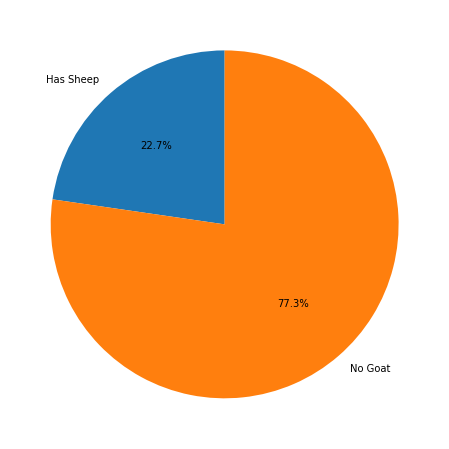

In [3]:
# Sheep: 0, Goat: 1
label = 'Has Sheep', 'No Goat'
plt.figure(figsize=(8, 8))
plt.pie(labels.groupby('sheep_or_goat').size(), labels=label, autopct='%0.1f%%', startangle=90)
plt.show()

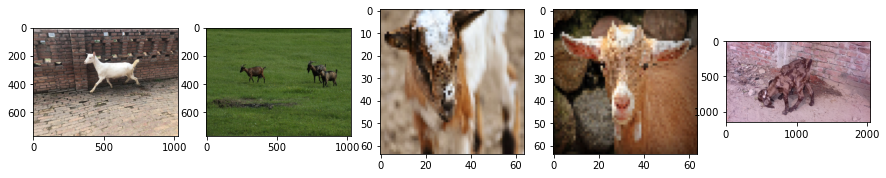

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(labels[labels['sheep_or_goat'] == 1]['id'][-5:]):
    path = os.path.join(train_path, idx)
    ax[i].imshow(img.imread(path))

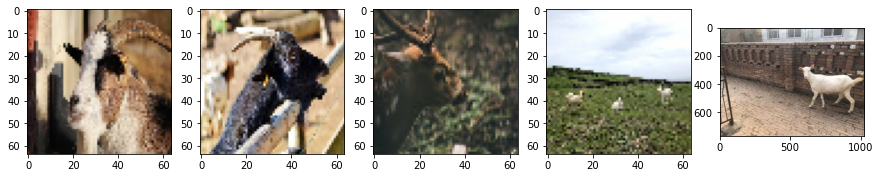

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(labels[labels['sheep_or_goat'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[i].imshow(img.imread(path))


In [6]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [7]:
class SheepGoatDataset(Dataset):
    def __init__(self, data, path, transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        img_name, label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

valid_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

In [9]:
train_data, valid_data = train_test_split(labels, stratify=labels.sheep_or_goat, test_size=0.2)

In [10]:
train_data = SheepGoatDataset(train_data, train_path, train_transform )
valid_data = SheepGoatDataset(valid_data, train_path, valid_transform )
test_data = SheepGoatDataset(submission, test_path, test_transform )


In [11]:
num_epochs = 50
num_classes = 2
batch_size = 5
learning_rate = 0.001

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
torch.cuda.empty_cache()

In [13]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Images
torch.Size([3, 224, 224])


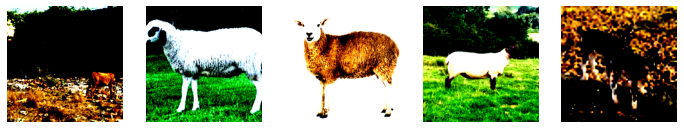

In [14]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('Training Images')
for i in range(5):
    axe1 = axes[i]
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

In [15]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        self.layer6 = vgg_fc_layer(7*7*512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = nn.Linear(4096, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        vgg16_features = self.layer5(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return vgg16_features, out

In [17]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
print(model)

CNN(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
   

In [18]:
%%time
# keeping-track-of-losses
for epoch in range(num_epochs):

    avg_loss = 0
    cnt = 0
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        _, outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.data
        cnt += 1
        print("[E: %d] loss: %f, avg_loss: %f" % (epoch, loss.data, avg_loss/cnt))
        loss.backward()
        optimizer.step()
    scheduler.step(avg_loss)

# Test the model
model.eval()
correct = 0
total = 0

for images, labels in valid_loader:
    images = images.cuda()
    _, outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
    print(predicted, labels, correct, total)
    print("avg acc: %f" % (100* correct/total))

# Save the Trained Model
torch.save(model.state_dict(), 'cnn.pkl')

[E: 0] loss: 0.909276, avg_loss: 0.909276
[E: 0] loss: 1.400272, avg_loss: 1.154774
[E: 0] loss: 3.162503, avg_loss: 1.824017
[E: 0] loss: 0.576623, avg_loss: 1.512169
[E: 0] loss: 0.655927, avg_loss: 1.340920
[E: 0] loss: 4.941501, avg_loss: 1.941017
[E: 0] loss: 2.140666, avg_loss: 1.969538
[E: 0] loss: 1.465238, avg_loss: 1.906501
[E: 0] loss: 1.744591, avg_loss: 1.888511
[E: 0] loss: 1.874998, avg_loss: 1.887159
[E: 0] loss: 0.054550, avg_loss: 1.720559
[E: 0] loss: 0.196036, avg_loss: 1.593515
[E: 0] loss: 0.563995, avg_loss: 1.514321
[E: 0] loss: 0.933379, avg_loss: 1.472825
[E: 0] loss: 0.814891, avg_loss: 1.428963
[E: 0] loss: 4.206810, avg_loss: 1.602579
[E: 0] loss: 0.395028, avg_loss: 1.531546
[E: 0] loss: 0.301170, avg_loss: 1.463192
[E: 0] loss: 0.159569, avg_loss: 1.394580
[E: 0] loss: 1.769198, avg_loss: 1.413311
[E: 0] loss: 1.030957, avg_loss: 1.395104
[E: 0] loss: 0.030269, avg_loss: 1.333066
[E: 0] loss: 2.063906, avg_loss: 1.364841
[E: 0] loss: 0.056599, avg_loss: 1